In [ ]:
# !pip install --upgrade scipy

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import sympy as sp

In [ ]:
# Déclaration des symboles
x, y, k_x, k_y, omega = sp.symbols('x y k_x k_y omega')

# Définition de la fonction phi
phi = sp.Function('phi')(x, y)

# Calcul des dérivées partielles secondes
d2phi_dx2 = phi.diff(x, x)
d2phi_dy2 = phi.diff(y, y)

# Calcul du laplacien
laplacian_phi = d2phi_dx2 + d2phi_dy2

# Définition de l'équation de Helmholtz
equation = sp.Eq(-laplacian_phi - omega**2 * phi, 0)

# Affichage de l'équation
display(equation)

Eq(-omega**2*phi(x, y) - Derivative(phi(x, y), (x, 2)) - Derivative(phi(x, y), (y, 2)), 0)

In [ ]:
# Génération des valeurs



def generate_k(lambda_value):
    # Générer kx et ky aléatoirement
    k_magnitude = 2 * np.pi / lambda_value
    theta = np.random.uniform(0, 2 * np.pi)  # Angle aléatoire entre 0 et 2pi
    kx = k_magnitude * np.cos(theta)
    ky = k_magnitude * np.sin(theta)
    return kx, ky

lambda_val = 1
omega = 2*np.pi/lambda_val
k_x, k_y = generate_k(lambda_val)

print(f"k_x: {k_x}, k_y: {k_y}")



k_x: -4.388601789974974, k_y: 4.496508860592391


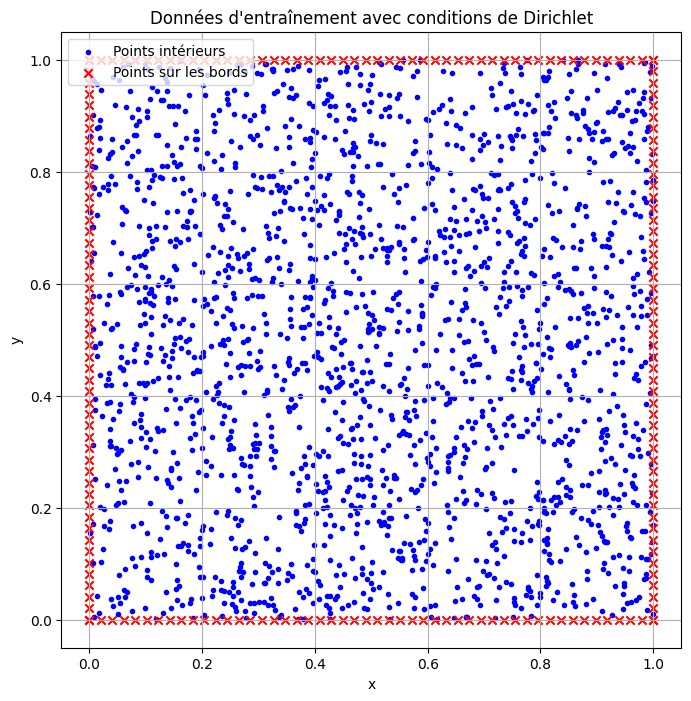

In [ ]:
# Définition des données d'entraînement
n_interior = 2000  # Nombre de points à l'intérieur du domaine
n_boundary = 50  # Nombre de points sur les bords

# Points à l'intérieur du domaine
x_interior = np.random.uniform(low=0, high=1, size=(n_interior, 2))

# Points sur les bords
x_boundary = np.vstack([
    np.linspace(0, 1, n_boundary),  # Bord inférieur (y=0)
    np.zeros(n_boundary),
]).T
x_boundary = np.vstack([x_boundary, np.vstack([
    np.linspace(0, 1, n_boundary),  # Bord supérieur (y=1)
    np.ones(n_boundary),
]).T])
x_boundary = np.vstack([x_boundary, np.vstack([
    np.zeros(n_boundary),  # Bord gauche (x=0)
    np.linspace(0, 1, n_boundary),
]).T])
x_boundary = np.vstack([x_boundary, np.vstack([
    np.ones(n_boundary),  # Bord droit (x=1)
    np.linspace(0, 1, n_boundary),
]).T])

# Valeurs de la solution sur les bords (conditions de Dirichlet)
u_boundary = np.exp(-1j * (k_x * x_boundary[:, 0] + k_y * x_boundary[:, 1]))  # Fonction définie par la condition


# Affichage des données d'entraînement
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(x_interior[:, 0], x_interior[:, 1], c='b', marker='.', label='Points intérieurs')
plt.scatter(x_boundary[:, 0], x_boundary[:, 1], c='r', marker='x', label='Points sur les bords')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Données d\'entraînement avec conditions de Dirichlet')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Définition du modèle PINN
model = tf.keras.Sequential([
    layers.Dense(50, activation='tanh', input_shape=(2,)),
    layers.Dense(50, activation='tanh'),
    layers.Dense(1, activation='linear')
])

# Compilation du modèle
model.compile(optimizer='adam', loss='mse')  # Utilisation de la perte MSE (Mean Squared Error)

# Entraînement du modèle
history = model.fit(
    np.vstack([x_interior, x_boundary]),  # Données d'entraînement
    np.vstack([np.zeros((n_interior, 1)), u_boundary[:, None]]),  # Valeurs cibles
    epochs=100,  # Nombre d'époques
    batch_size=32,  # Taille du lot
    verbose=1  # Affichage des détails de l'entraînement
)

Epoch 1/100


69/69 [==============================] - 1s 2ms/step - loss: 0.0504
Epoch 2/100
69/69 [==============================] - 0s 2ms/step - loss: 0.0489
Epoch 3/100
69/69 [==============================] - 0s 2ms/step - loss: 0.0483
Epoch 4/100
69/69 [==============================] - 0s 2ms/step - loss: 0.0494
Epoch 5/100
69/69 [==============================] - 0s 2ms/step - loss: 0.0491
Epoch 6/100
69/69 [==============================] - 0s 2ms/step - loss: 0.0490
Epoch 7/100
69/69 [==============================] - 0s 3ms/step - loss: 0.0487
Epoch 8/100
69/69 [==============================] - 0s 3ms/step - loss: 0.0475
Epoch 9/100
69/69 [==============================] - 0s 3ms/step - loss: 0.0482
Epoch 10/100
69/69 [==============================] - 0s 3ms/step - loss: 0.0476
Epoch 11/100
69/69 [==============================] - 0s 2ms/step - loss: 0.0470
Epoch 12/100
69/69 [==============================] - 0s 3ms/step - loss: 0.0470
Epoch 13/100
69/69 [=============================

In [ ]:
def custom_loss(model, x_interior, x_boundary, u_boundary, omega):
    x_interior_tf = tf.convert_to_tensor(x_interior, dtype=tf.float32)
    x_boundary_tf = tf.convert_to_tensor(x_boundary, dtype=tf.float32)

    u_pred_interior = model(x_interior_tf)
    u_pred_boundary = model(x_boundary_tf)

    # Calcul du Laplacien des prédictions
    with tf.GradientTape() as tape:
        tape.watch(x_interior_tf)
        laplacian_u_interior = tf.gradients(tf.gradients(u_pred_interior, x_interior_tf), x_interior_tf)
        laplacian_u_interior = laplacian_u_interior[0][:, 0] + laplacian_u_interior[0][:, 1]  # Laplacien en 2D

    # Calcul du résidu sur les points intérieurs
    residue_interior = -laplacian_u_interior - omega**2 * u_pred_interior
    loss_interior = tf.reduce_mean(tf.square(residue_interior))

    # Calcul du résidu sur les points sur les bords avec les conditions aux limites
    loss_boundary = tf.reduce_mean(tf.square(u_pred_boundary - u_boundary))

    return loss_interior + loss_boundary


In [ ]:
model.compile(optimizer='adam', loss=lambda y_true, y_pred: custom_loss(model, x_interior, x_boundary, u_boundary, omega))


In [ ]:
history = model.fit(
    np.vstack([x_interior, x_boundary]),  # Données d'entraînement
    np.vstack([np.zeros((n_interior, 1)), u_boundary[:, None]]),  # Valeurs cibles
    epochs=100,  # Nombre d'époques
    batch_size=32,  # Taille du lot
    verbose=1  # Affichage des détails de l'entraînement
)



Epoch 1/100
69/69 [==============================] - 5s 59ms/step - loss: 10.2926
Epoch 2/100
69/69 [==============================] - 4s 64ms/step - loss: 1.7219
Epoch 3/100
69/69 [==============================] - 5s 74ms/step - loss: 0.8747
Epoch 4/100
69/69 [==============================] - 4s 63ms/step - loss: 0.6807
Epoch 5/100
69/69 [==============================] - 5s 68ms/step - loss: 0.6110
Epoch 6/100
69/69 [==============================] - 5s 69ms/step - loss: 0.5781
Epoch 7/100
69/69 [==============================] - 4s 62ms/step - loss: 0.5618
Epoch 8/100
69/69 [==============================] - 5s 71ms/step - loss: 0.5521
Epoch 9/100
69/69 [==============================] - 12s 169ms/step - loss: 0.5465
Epoch 10/100
69/69 [==============================] - 7s 95ms/step - loss: 0.5434
Epoch 11/100
69/69 [==============================] - 4s 61ms/step - loss: 0.5398
Epoch 12/100
69/69 [==============================] - 5s 68ms/step - loss: 0.5398
Epoch 13/100
69/69 [==

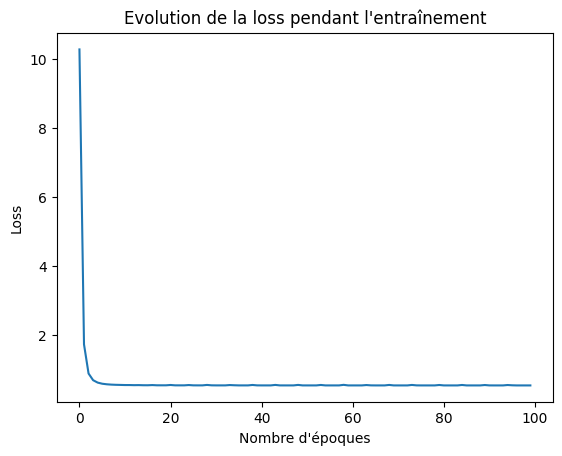

In [ ]:
# Tracer la loss en fonction du nombre d'époques
plt.plot(history.history['loss'])
plt.title('Evolution de la loss pendant l\'entraînement')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Loss')
plt.show()


313/313 [==============================] - 1s 2ms/step


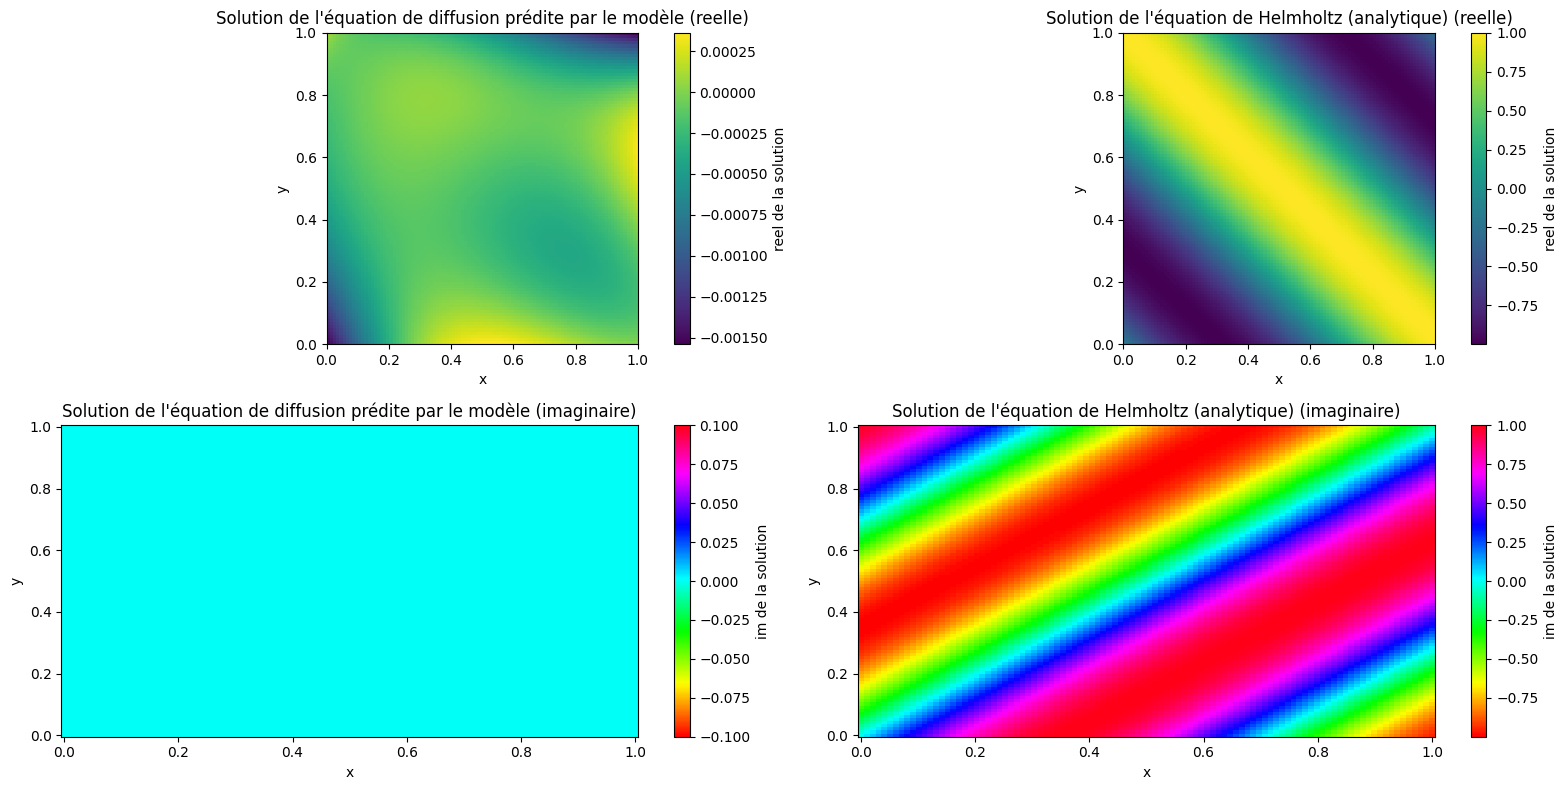

In [ ]:
# Générer une grille de points à l'intérieur du domaine
n_points = 100
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, n_points), np.linspace(0, 1, n_points))
points_grid = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

# Prédire les valeurs de la solution sur la grille
solution_predicted = model.predict(points_grid).reshape(n_points, n_points)

# Calculer les valeurs de la solution analytique sur la grille de points
analytical_solution_values = np.exp(-1j * (k_x * points_grid[:, 0] + k_y * points_grid[:, 1]))

# Tracer la solution prédite par le modèle et la solution analytique
plt.figure(figsize=(16, 8))

# Solution prédite par le modèle réelle
plt.subplot(2, 2, 1)
plt.imshow(np.real(solution_predicted), cmap='viridis', extent=[0, 1, 0, 1])
plt.colorbar(label='reel de la solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution de l\'équation de diffusion prédite par le modèle (reelle)')

# Solution analytique réelle
plt.subplot(2, 2, 2)
plt.imshow(np.real(analytical_solution_values).reshape(n_points, n_points), cmap='viridis', extent=[0, 1, 0, 1])
plt.colorbar(label='reel de la solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution de l\'équation de Helmholtz (analytique) (reelle)')

# Solution prédite par le modèle imaginaire
plt.subplot(2, 2, 3)
plt.pcolormesh(x_grid, y_grid, np.imag(solution_predicted), cmap='hsv', shading='auto')
plt.colorbar(label='im de la solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution de l\'équation de diffusion prédite par le modèle (imaginaire)')

# Solution analytique imaginaire
plt.subplot(2, 2, 4)
plt.pcolormesh(x_grid, y_grid, np.imag(analytical_solution_values).reshape(n_points, n_points), cmap='hsv', shading='auto')
plt.colorbar(label='im de la solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution de l\'équation de Helmholtz (analytique) (imaginaire)')

plt.tight_layout()
plt.show()
